In [2]:
# Imports
import pandas as pd
import re
import numpy as np
from pmdarima import auto_arima
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Read the Excel file
county_raw = pd.read_excel('1997-2017年中国县级尺度碳排放.xlsx', sheet_name='Unit (Million tons)')
city_2020_raw = pd.read_excel('20221016_164053_474470.xlsx', sheet_name='二氧化碳排放(万吨)')
city_2015_raw = pd.read_excel('20221016_164004_290052.xlsx', sheet_name='二氧化碳排放(万吨)')
city_2010_raw = pd.read_excel('20221016_163454_333468.xlsx', sheet_name='二氧化碳排放(万吨)')
city_2005_raw = pd.read_excel('20221016_163805_882972.xlsx', sheet_name='二氧化碳排放(万吨)')

In [4]:
# Define a function to combine the province and city names
def combine_province_city(row):
    if row['省份\nProvince'] in ['北京', '天津', '重庆', '上海']:
        return row['省份\nProvince']
    else:
        if row['城市名称\nCity'] in ['湖北直辖县', '河南直辖县', '海南直辖县']:
            return row['城市名称\nCity']
        else:
            return row['省份\nProvince'] + row['城市名称\nCity']
    
# Define a function to remove non-Chinese characters
def remove_non_chinese(text):
    return re.sub('[^\u4e00-\u9fff]', '', text)

# Define a function to prepare the city dataset
def prepare_city(df):
    df['城市'] = df.apply(combine_province_city, axis=1)
    selected_columns = df[[
        '城市', '农业\nAgriculture', '服务业\nService', '工业\nIndustrial total',
        '城镇生活\nUrban household', '农村生活\nRural household', '生活\nHousehold',
        '交通\nTransport', '直接排放\nDirect', '间接排放\nIndirect', '总排放\nTotal'
    ]].copy()
    selected_columns.columns = map(remove_non_chinese, selected_columns.columns)
    selected_columns['产业'] = selected_columns['农业'] + selected_columns['服务业'] + selected_columns['工业']
    final_columns = ['城市', '农业', '工业', '服务业', '产业', '城镇生活', '农村生活', '生活', '交通', '直接排放', '间接排放', '总排放']
    final_df = selected_columns[final_columns]
    return final_df

# Select data
city_2020_select = prepare_city(city_2020_raw)
city_2015_select = prepare_city(city_2015_raw)
city_2010_select = prepare_city(city_2010_raw)
city_2005_select = prepare_city(city_2005_raw)

city_2020 = city_2020_select[['城市', '总排放']].rename(columns={'总排放': '2020'})
city_2015 = city_2015_select[['城市', '总排放']].rename(columns={'总排放': '2015'})
city_2010 = city_2010_select[['城市', '总排放']].rename(columns={'总排放': '2010'})
city_2005 = city_2005_select[['城市', '总排放']].rename(columns={'总排放': '2005'})

# 使用“城市”列作为键合并这四个数据集
from functools import reduce
dfs = [city_2005, city_2010, city_2015, city_2020]
city_allyear = reduce(lambda left, right: pd.merge(left, right, on='城市', how='outer'), dfs)

In [5]:
# Define a function to simplify the administrative name
def simplify_administrative_name(name):
    ethnic_groups = [
        '汉族', '蒙古族', '回族', '藏族', '维吾尔族', '苗族', '彝族', '壮族',
        '布依族', '朝鲜族', '满族', '侗族', '瑶族', '白族', '土家族', '哈尼族',
        '哈萨克族', '傣族', '黎族', '傈僳族', '佤族', '畲族', '高山族', '拉祜族',
        '水族', '东乡族', '纳西族', '景颇族', '柯尔克孜族', '土族', '达斡尔族', '仫佬族',
        '羌族', '布朗族', '撒拉族', '毛难族', '仡佬族', '锡伯族', '阿昌族', '普米族',
        '塔吉克族', '怒族', '乌孜别克族', '俄罗斯族', '鄂温克族', '德昂族', '保安族', '裕固族',
        '京族', '塔塔尔族', '独龙族', '鄂伦春族', '赫哲族', '门巴族', '珞巴族', '基诺族', '维吾尔', '哈萨克'
    ]
    ethnic_pattern = '|'.join(ethnic_groups)
    if pd.isnull(name) or not isinstance(name, str):
        return None  
    name = re.sub(f'({ethnic_pattern}).*$', '', name)
    name = re.sub(r'巴音郭楞蒙古', '巴音郭楞', name)
    name = re.sub(r'博尔塔拉蒙古', '博尔塔拉', name)
    name = re.sub(r'(.*?)(自治区|自治州|自治县|市|省|地区|特别行政区|县|旗|自治旗|区|林区|特区|盟)?$', r'\1', name)
    return name.strip()

# 应用函数到 'City Name' 和 'Province Name' 列
county_raw['City Name Simplified'] = county_raw['City Name'].apply(simplify_administrative_name)
county_raw['Province Name Simplified'] = county_raw['Province Name'].apply(simplify_administrative_name)

# Define a function to combine the province and city names
def combine_province_city_county(row):
    if row['Province Name Simplified'] in ['北京', '天津', '重庆', '上海']:
        return row['Province Name Simplified']
    else:
        return f"{row['Province Name Simplified']}{row['City Name Simplified']}"

# Reshape the county dataset
county_raw['城市'] = county_raw.apply(combine_province_city_county, axis=1)
county_raw.rename(columns={'County Name': '县'}, inplace=True)
pattern = re.compile(r'.*?\d{4}.*?')
columns_with_four_digits = [col for col in county_raw.columns if pattern.match(col)]
for col in columns_with_four_digits:
    county_raw[col] = county_raw[col].astype(float) * 100
columns_to_keep = ['城市', '县'] + columns_with_four_digits
county_select = county_raw[columns_to_keep]
county_select.columns = [col[1:] if col.startswith('C') and any(char.isdigit() for char in col) else col for col in county_select.columns]
county_select = county_select.dropna()

In [6]:
# Group the county dataset
columns_to_aggregate = [col for col in county_select.columns if col != '县']
county_grouped = county_select[columns_to_aggregate].groupby('城市').sum()
county_grouped = county_grouped.reset_index()

# Compare two datasets
cities_in_county_grouped = set(county_grouped['城市'].unique())
cities_in_city = set(city_allyear['城市'].unique())
cities_only_in_county_grouped = cities_in_county_grouped - cities_in_city
cities_only_in_city = cities_in_city - cities_in_county_grouped
print("只在county_grouped中存在的城市:", cities_only_in_county_grouped)
print("只在city中存在的城市:", cities_only_in_city)

# Merge two datasets
county_grouped.columns = ['A' + col if col != '城市' else col for col in county_grouped.columns]
city_allyear.columns = ['B' + col if col != '城市' else col for col in city_allyear.columns]
city = pd.merge(county_grouped, city_allyear, on='城市', how='inner')

# Clean the County dataset
cities_in_city = set(city['城市'])
county = county_select[county_select['城市'].isin(cities_in_city)]
county.to_csv('analysis\county.csv', index=False)
city.to_csv('analysis\city.csv', index=False)

只在county_grouped中存在的城市: {'海南文昌', '安徽巢湖', '新疆阿拉尔', '湖北潜江', '河南济源', '新疆图木舒克', '海南五指山', '海南昌江', '海南陵水', '山东莱芜', '海南屯昌', '海南琼海', '海南临高', '新疆石河子', '海南乐东', '湖北天门', '海南万宁', '海南白沙', '湖北仙桃', '海南定安', '海南澄迈', '新疆五家渠', '湖北神农架', '海南东方'}
只在city中存在的城市: {'西藏昌都', '河南直辖县', '西藏山南', '西藏那曲', '西藏拉萨', '湖北直辖县', '西藏林芝', '西藏日喀则', '西藏阿里', '海南直辖县'}


In [7]:
# Calculate the proportion of county to city
year_columns_county = [col for col in county.columns if col.isdigit()]
county_proportion = county[['城市', '县']].copy()

for year in year_columns_county:
    year_column_city = f'A{year}'
    merged_df = county[['城市', '县', year]].merge(city[['城市', year_column_city]], on='城市')
    proportion_column_name = f'Proportion_{year}'
    merged_df[proportion_column_name] = merged_df[year] / merged_df[year_column_city]
    county_proportion = county_proportion.merge(merged_df[['城市', '县', proportion_column_name]], on=['城市', '县'], how='left')

county_proportion.columns = [col.replace('Proportion_', '') for col in county_proportion.columns]

In [8]:
# Define a function to predict the proportion
def arima_predict(ts, start_year, end_year):
    model = auto_arima(ts, m=1, suppress_warnings=True)
    forecast = model.predict(n_periods=end_year - start_year + 1)
    return forecast

# Years
start_year = 2018
end_year = 2020
year_columns = [str(year) for year in range(1997, 2018)]

# Prepare the proportion predictions dataframe
columns = ['城市', '县']
proportion_predictions = pd.DataFrame(columns=columns)
amount_predictions = pd.DataFrame(columns=columns)

# Predict the proportion
for index, row in county_proportion.iterrows():
    ts = row[year_columns].values.astype(np.float64)
    proportion_forecast = arima_predict(ts, start_year, end_year)
    proportion_forecast_data = {year: [proportion_forecast[i]] for i, year in enumerate(range(start_year, end_year + 1))}
    proportion_forecast_data['城市'] = row['城市']
    proportion_forecast_data['县'] = row['县']
    proportion_predictions = pd.concat([proportion_predictions, pd.DataFrame(proportion_forecast_data)], ignore_index=True)
print("PROPORTION PREDICT FINISHED")

# Adjust the proportion predictions
for year in [2018, 2019, 2020]:
    proportion_predictions[year] = proportion_predictions[year].apply(lambda x: 1 if x == 0 else x)
    proportion_predictions[f'Adj_{year}'] = proportion_predictions.groupby('城市')[float(year)].transform(lambda x: x / x.sum())
    
# Amount (2020) predictions based on the proportion predictions
city_renamed = city[['城市', 'B2020']].rename(columns={'B2020': 'City_B2020'})
proportion_predictions = proportion_predictions.merge(city_renamed, on='城市', how='left')
proportion_predictions['Amount_2020'] = proportion_predictions['Adj_2020'] * proportion_predictions['City_B2020']
proportion_predictions.drop(columns=['City_B2020'], inplace=True)

# Predict the amount
for index, row in county.iterrows():
    ts = row[year_columns].values.astype(np.float64)
    amount_forecast = arima_predict(ts, start_year, end_year)
    amount_forecast_data = {year: [amount_forecast[i]] for i, year in enumerate(range(start_year, end_year + 1))}
    amount_forecast_data['城市'] = row['城市']
    amount_forecast_data['县'] = row['县']
    amount_predictions = pd.concat([amount_predictions, pd.DataFrame(amount_forecast_data)], ignore_index=True)
print("AMOUNT PREDICT FINISHED")

# Output the results
proportion_predictions.to_csv(r'analysis\proportion_predictions.csv', index=False)
amount_predictions.to_csv(r'analysis\amount_predictions.csv', index=False)

c:\Users\xianl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\xianl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\xianl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\xianl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\xianl\AppDa

PROPORTION PREDICT FINISHED
AMOUNT PREDICT FINISHED


In [9]:
# Rename the columns
proportion_predictions_renamed = proportion_predictions.rename(columns={
    '县': '区县',
    2020: '2020占比_无约束',
    'Adj_2020': '2020占比_约束',
    'Amount_2020': '2020_CCG'
})
amount_predictions_renamed = amount_predictions.rename(columns={
    '县': '区县',
    2020: '2020_CEADs'
})

# Calculate the results
result = pd.merge(
    proportion_predictions_renamed[['城市', '区县', '2020占比_无约束', '2020占比_约束', '2020_CCG']], 
    amount_predictions_renamed[['城市', '区县', '2020_CEADs']], 
    on=['城市', '区县']
)
result['2020_均值'] = result[['2020_CCG', '2020_CEADs']].mean(axis=1)
result['2020_差值'] = abs(result['2020_CCG'] - result['2020_CEADs'])
result['2020_SMAPE'] = 2 * abs(result['2020_CCG'] - result['2020_CEADs']) / (result['2020_CCG'] + result['2020_CEADs'])
result['2020_差异水平'] = 2 * abs(result['2020_CCG'] - result['2020_CEADs']) * abs(result['2020_CCG'] - result['2020_CEADs']) / abs(result['2020_CCG'] + result['2020_CEADs'])
result.to_csv(r'result\result.csv', index=False)

# Define the areas
chengdu_areas = {
    '四川成都': '全部区县',
    '四川德阳': ['旌阳区', '什邡市', '广汉市', '中江县'],
    '四川眉山': ['东坡区', '彭山县', '仁寿县', '青神县'],
    '四川资阳': ['雁江区', '乐至县']
}

chongqing_areas = {
    '重庆': [
        '渝中区', '大渡口区', '江北区', '沙坪坝区', '九龙坡区', '南岸区', '北碚区', '渝北区', '巴南区', 
        '涪陵区', '长寿区', '江津区', '合川区', '永川区', '南川区', '綦江县', '大足县', 
        '璧山县', '铜梁县', '潼南县', '荣昌县'
    ],
    '四川广安': '全部区县'
}

# Define a function to select data
attempted_matches = []
def select_data(df, areas):
    frames = []
    for city, counties in areas.items():
        if counties == '全部区县':
            frames.append(df[df['城市'] == city])
            attempted_matches.extend(df[df['城市'] == city]['区县'].unique().tolist())
        else:
            for county in counties:
                attempted_matches.append(county)  # 记录尝试匹配的区县
                matched_df = df[(df['城市'] == city) & (df['区县'] == county)]
                if not matched_df.empty:
                    frames.append(matched_df)
                else:
                    print(f"未找到匹配的区县: {city} {county}")
    selected_df = pd.concat(frames, ignore_index=True)
    selected_df['区县'].replace({
        '彭山县': '彭山区',
        '綦江县': '綦江区—万盛经开区',
        '大足县': '大足区',
        '璧山县': '璧山区',
        '铜梁县': '铜梁区',
        '潼南县': '潼南区',
        '荣昌县': '荣昌区',
    }, inplace=True)
    return selected_df

# Select data
chengdu = select_data(result, chengdu_areas)
chongqing = select_data(result, chongqing_areas)

# Output the results
chengdu.to_csv(r'result\chengdu.csv', index=False)
chongqing.to_csv(r'result\chongqing.csv', index=False)

In [10]:
# Compare the results
city_compare = city[['城市', 'A2005', 'A2010', 'A2015', 'B2005', 'B2010', 'B2015']].copy()
county_compare = county[['城市', '县', '2005', '2010', '2015']].copy()
city_compare['B2005'] = city_compare['B2005'].astype(float)
city_compare['B2010'] = city_compare['B2010'].astype(float)
city_compare['B2015'] = city_compare['B2015'].astype(float)

merged_dataframe = pd.merge(county_proportion, city_compare, on='城市')
merged_dataframe['2005_CCG'] = merged_dataframe['B2005'] * merged_dataframe['2005']
merged_dataframe['2010_CCG'] = merged_dataframe['B2010'] * merged_dataframe['2010']
merged_dataframe['2015_CCG'] = merged_dataframe['B2015'] * merged_dataframe['2015']
merged_dataframe = merged_dataframe[['城市', '县', '2005_CCG', '2010_CCG', '2015_CCG']]

county_compare = pd.merge(county_compare, merged_dataframe, on=['城市', '县'])
county_compare = county_compare.rename(columns={
    '县': '区县',
    '2005': '2005_CEADs',
    '2010': '2010_CEADs',
    '2015': '2015_CEADs'
})

county_compare['2005_差值'] = abs(county_compare['2005_CCG'] - county_compare['2005_CEADs'])
county_compare['2010_差值'] = abs(county_compare['2010_CCG'] - county_compare['2010_CEADs'])
county_compare['2015_差值'] = abs(county_compare['2015_CCG'] - county_compare['2015_CEADs'])

county_compare['2005_SMAPE'] = 2 * abs(county_compare['2005_CCG'] - county_compare['2005_CEADs']) / abs(county_compare['2005_CCG'] + county_compare['2005_CEADs'])
county_compare['2010_SMAPE'] = 2 * abs(county_compare['2010_CCG'] - county_compare['2010_CEADs']) / abs(county_compare['2010_CCG'] + county_compare['2010_CEADs'])
county_compare['2015_SMAPE'] = 2 * abs(county_compare['2015_CCG'] - county_compare['2015_CEADs']) / abs(county_compare['2015_CCG'] + county_compare['2015_CEADs'])

county_compare['2005_差异水平'] = 2 * abs(county_compare['2005_CCG'] - county_compare['2005_CEADs']) * abs(county_compare['2005_CCG'] - county_compare['2005_CEADs']) / abs(county_compare['2005_CCG'] + county_compare['2005_CEADs'])
county_compare['2010_差异水平'] = 2 * abs(county_compare['2010_CCG'] - county_compare['2010_CEADs']) * abs(county_compare['2010_CCG'] - county_compare['2010_CEADs']) / abs(county_compare['2010_CCG'] + county_compare['2010_CEADs'])
county_compare['2015_差异水平'] = 2 * abs(county_compare['2015_CCG'] - county_compare['2015_CEADs']) * abs(county_compare['2015_CCG'] - county_compare['2015_CEADs']) / abs(county_compare['2015_CCG'] + county_compare['2015_CEADs'])

county_compare = pd.merge(county_compare, result[['城市', '区县', '2020_差值', '2020_SMAPE', '2020_差异水平', '2020_CCG', '2020_CEADs','2020_均值']], on=['城市', '区县'], how='left')

C:\Users\xianl\AppData\Local\Temp\ipykernel_16228\3686705703.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_difference['平均差值'] = (county_difference['2005_差值'] + county_difference['2010_差值'] + county_difference['2015_差值'] + county_difference['2020_差值']) / 4
C:\Users\xianl\AppData\Local\Temp\ipykernel_16228\3686705703.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_difference['平均SMAPE'] = (county_difference['2005_SMAPE'] + county_difference['2010_SMAPE'] + county_difference['2015_SMAP

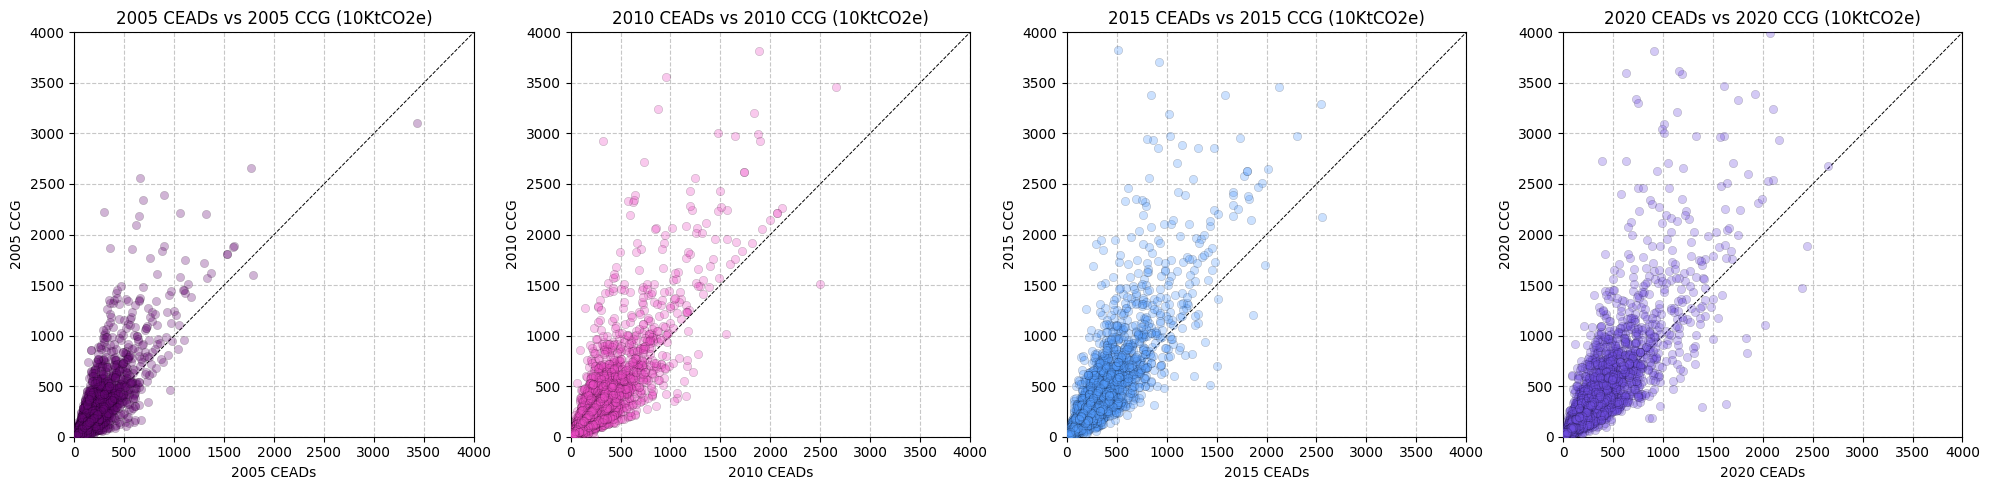

In [18]:
years = [2005, 2010, 2015]
deviation_cols = ['2005_CCG', '2010_CCG', '2015_CCG']
regression = []

for _, row in county_compare.iterrows():
    y = row[deviation_cols].values
    X = sm.add_constant(years)
    model = sm.OLS(y, X).fit()
    predicted_2020 = model.predict([1, 2020])
    regression.append({
        '城市': row['城市'],
        '区县': row['区县'],
        '2020_CCG五年期': predicted_2020[0]
    })

regression_combine = pd.DataFrame(regression)
county_results = pd.merge(county_compare, regression_combine, on=['城市', '区县'], how='left')

ordered_columns = [
    '城市', '区县', 
    '2005_CEADs', '2005_CCG', '2005_差值', '2005_SMAPE', '2005_差异水平',
    '2010_CEADs', '2010_CCG', '2010_差值', '2010_SMAPE', '2010_差异水平',
    '2015_CEADs', '2015_CCG', '2015_差值', '2015_SMAPE', '2015_差异水平',
    '2020_CEADs', '2020_CCG', '2020_差值', '2020_SMAPE', '2020_差异水平', '2020_均值', '2020_CCG五年期'
]
county_results = county_results[ordered_columns]
county_difference = county_results[['城市', '区县', '2005_SMAPE', '2005_差值', '2005_差异水平', '2010_SMAPE', '2010_差值', '2010_差异水平', '2015_SMAPE', '2015_差值', '2015_差异水平', '2020_SMAPE', '2020_差值', '2020_差异水平']]
county_difference['平均差值'] = (county_difference['2005_差值'] + county_difference['2010_差值'] + county_difference['2015_差值'] + county_difference['2020_差值']) / 4
county_difference['平均SMAPE'] = (county_difference['2005_SMAPE'] + county_difference['2010_SMAPE'] + county_difference['2015_SMAPE'] + county_difference['2020_SMAPE']) / 4
county_difference['平均差异水平'] = (county_difference['2005_差异水平'] + county_difference['2010_差异水平'] + county_difference['2015_差异水平'] + county_difference['2020_差异水平']) / 4
chongqing_difference = select_data(county_difference, chongqing_areas)
chengdu_difference = select_data(county_difference, chengdu_areas)

# Plot
plt.figure(figsize=(20, 5))

years = ['2005', '2010', '2015', '2020']
colors = ['#660874', '#EE4CC6', '#549DFF', '#704EE1']
edgecolors = ['black'] * 4

for i, year in enumerate(years):
    plt.subplot(1, 4, i + 1)
    plt.scatter(county_results[f'{year}_CEADs'], county_results[f'{year}_CCG'], color=colors[i], edgecolor=edgecolors[i], linewidth=0.3, alpha=0.3, zorder=3)
    max_val = max(county_results[f'{year}_CEADs'].max(), county_results[f'{year}_CCG'].max())
    plt.plot([0, max_val], [0, max_val], 'k--', lw=0.7, zorder=2)
    plt.title(f'{year} CEADs vs {year} CCG (10KtCO2e)')
    plt.xlim(0, 4000)
    plt.ylim(0, 4000) 
    plt.xlabel(f'{year} CEADs')
    plt.ylabel(f'{year} CCG')
    plt.grid(True, linestyle='--', alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()

In [21]:
difference = pd.concat([chongqing_difference, chengdu_difference])
difference.to_csv(r'analysis\difference.csv', index=False)
selected_county_results = county_results[['城市', '区县', '2020_CEADs', '2020_CCG', '2020_均值', '2020_CCG五年期', '2020_差异水平']]
chengdu_county_results = select_data(selected_county_results, chengdu_areas)
chongqing_county_results = select_data(selected_county_results, chongqing_areas)
chongqing_county_results.to_csv(r'analysis\chongqing_county_results.csv', index=False)
chengdu_county_results.to_csv(r'analysis\chengdu_county_results.csv', index=False)